# Домашнее задание №2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
from scipy.signal import argrelextrema
from scipy import signal
from scipy.signal import butter, lfilter

## Импортируем данные

In [2]:
contact = pd.read_csv("Contact.txt")
contact.head()

,20:37:41:030,519
0,20:37:41:070,507
1,20:37:41:110,501
2,20:37:41:150,501
3,20:37:41:190,504
4,20:37:41:230,508


In [3]:
geom = pd.read_csv("geom.txt",names=['x','y','z'],header=None,sep=' ')
geom.head()

,x,y,z
0,20.282408,13.224313,84.636943
1,53.698406,67.169669,135.402828
2,53.553210,67.119487,135.558500
3,52.444081,65.841050,133.247966
4,53.835639,67.188929,135.496609


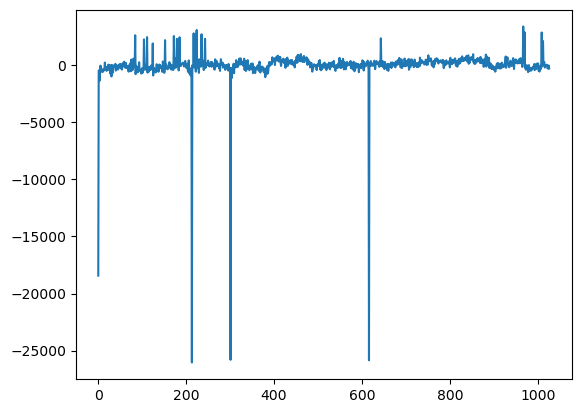

In [4]:
sig = geom['x']**2 + geom['y']**2 + geom['z']**2
plt.plot(sig - np.mean(sig))

## Строим спектры

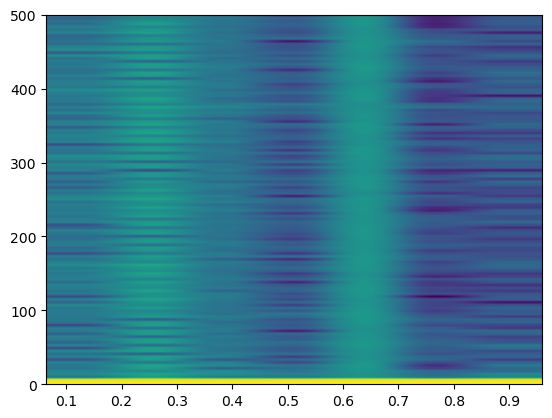

In [5]:
samplingFrequency = 1000
spectrum, freqs, t, im = plt.specgram(sig, Fs=samplingFrequency)

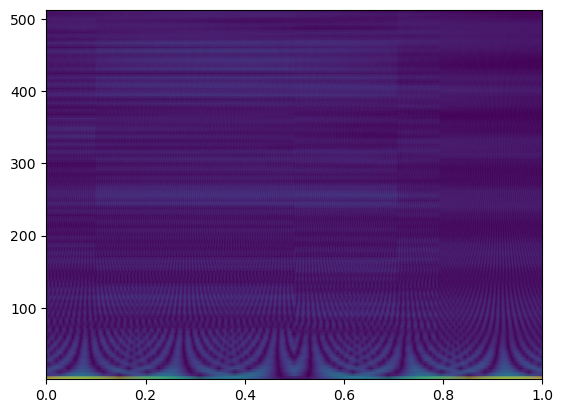

In [6]:
def GaborWavelet(points, width):
    omega = 1 / width
    Gabor_coef = 1
    t = np.arange(-points/2, points/2)
    return 0.325*np.sqrt(omega)*np.exp(-0.5*Gabor_coef*(t*omega*0.187)**2 + 1j * omega*t)

t, dt = np.linspace(0, 1, 1027, retstep=True)
fs = 1/dt
w=1000.


freq = np.linspace(1, fs/2, 100)
widths = w*fs / (2*freq*np.pi)

cwtm = signal.cwt(sig, signal.morlet2, widths, w=w)
plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
plt.show()

## Реализация алгоритма

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def estimation_hrf(i):
    s = cwtm[:,i] 
    t_start = 0.5 * i 
    signal_duration=np.size(sig)
    test_len = min(10, (signal_duration - t_start))
    x = sig[int(t_start):int(t_start+test_len)] 
    fmax = freq[np.argmax(s)] 
    if fmax > 2:
        threshold = 2.5
    else: 
        if fmax < 1:
            threshold = 1.5
        else:
            threshold = 2
    xsm = butter_bandpass_filter(x, 0.1, threshold, 1/dt, order=6)
    test = butter_bandpass_filter(signal.unit_impulse(100, 'mid'), 0.1, threshold, 5000, order=6)
    
    signalAmplitude = np.sin(xsm)
    plt.phase_spectrum(test, color ='green')
    n_zero_cross = np.size(np.where(np.diff(np.sign(xsm)))[0])
    n_loc_max = len(argrelextrema(xsm, np.greater))
    upper_estimate = 1/(test_len * n_loc_max)
    lower_estimate = 1/(test_len * 0.5 * max(n_zero_cross, 1))
    estimate = 0.5 * (lower_estimate + upper_estimate)
    F = np.argpartition(s, -3)[-3:] 
    fhr = np.argmin(s[1:] - estimate) 
    return fhr

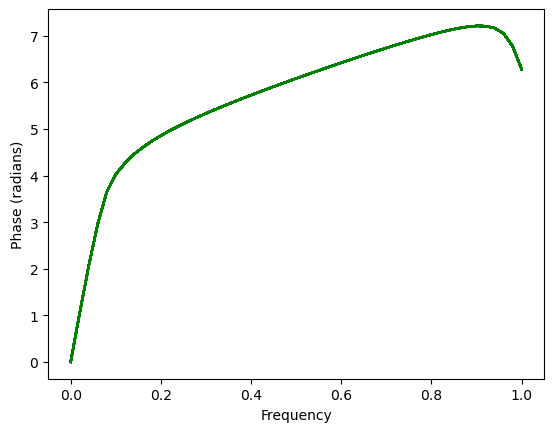

In [8]:
lst = list()
for i in range(len(cwtm)):
  lst.append(estimation_hrf(i))